In [45]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2


# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json
import datetime
import pickle


# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
pd.set_option('display.max_rows', 10)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from multiprocessing import cpu_count
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math
# import ffn


# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

RANDOM_STATE = 777

print()

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-08-23T11:05:06.111527-04:00

Python implementation: CPython
Python version       : 3.8.19
IPython version      : 8.12.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



/var/folders/j0/8v9qcjfx15g5ftmsy5n0qrq80000gn/T/ipykernel_93313/2173331131.py:46: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk')


In [46]:
import os

# Run the setup script
%run ../../config/setup_project.py

# Call the function to set up the project path
setup_project_path()

# Now you can import your modules
from utils import helper as h_
import ch_02.code_ch_02 as f_ch2
import ch_03.code_ch_03 as f_ch3

Project root added to sys.path: /Users/paulkelendji/Desktop/GitHub_paul/ML-Asset_Management/src
Current sys.path: ['/Users/paulkelendji/miniconda3/envs/financial_math/lib/python38.zip', '/Users/paulkelendji/miniconda3/envs/financial_math/lib/python3.8', '/Users/paulkelendji/miniconda3/envs/financial_math/lib/python3.8/lib-dynload', '', '/Users/paulkelendji/miniconda3/envs/financial_math/lib/python3.8/site-packages', '/Users/paulkelendji/miniconda3/envs/financial_math/lib/python3.8/site-packages/setuptools/_vendor', '/Users/paulkelendji/Desktop/GitHub_paul/ML-Asset_Management/src']


<Figure size 1000x700 with 0 Axes>

In [47]:
df = pd.read_parquet("../../data/IVE_kibot.parq")

In [48]:
# load ../data/variables_ch2.pkl
%run ../ch_02/code_ch_02.py

path = '../../data/variables_ch2.pkl'
import pickle
with open(path, 'rb') as f:
    bars = pickle.load(f)
    bar_time = pickle.load(f)
    
# df as bars['Dollar'].df_OLHC without 'cusum' column
df = bars['Dollar'].df_OLHC.drop(columns=['cusum'])
# For the purpose of this example, remove rows where time_close is duplicated
# (keep the first row)
# Remove rows where time_close is duplicated, keeping the first occurrence
df = df.drop_duplicates(subset='time_close', keep='first')
# set index as 'time_close'
df = df.set_index('time_close')

In [49]:
# CLOSE PRICE AND DAILY VOLATILITY
# Step 1 : get the daily volatility
close = df['close']
dailyVol = f_ch3.getDailyVol(close, span0=100).dropna()

# from series to df
close = pd.DataFrame(close)
dailyVol = pd.DataFrame(dailyVol)

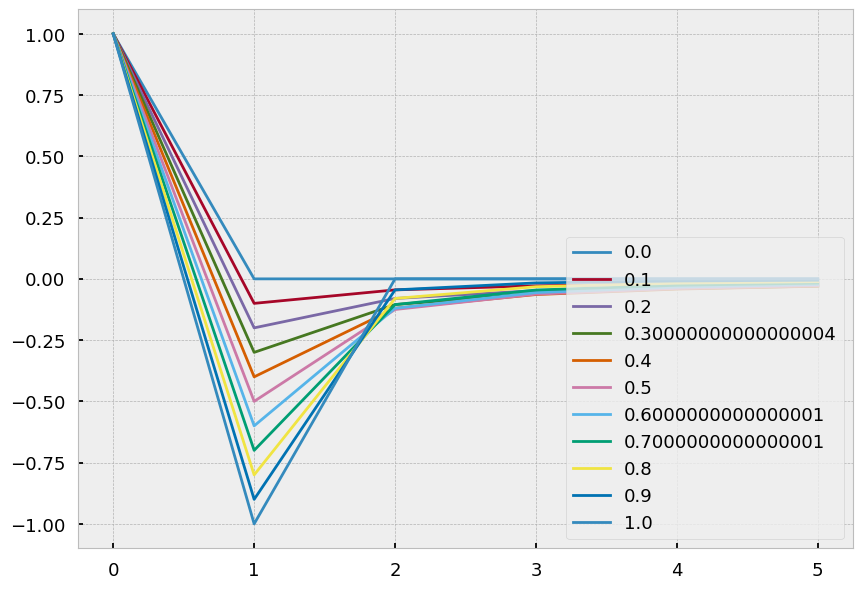

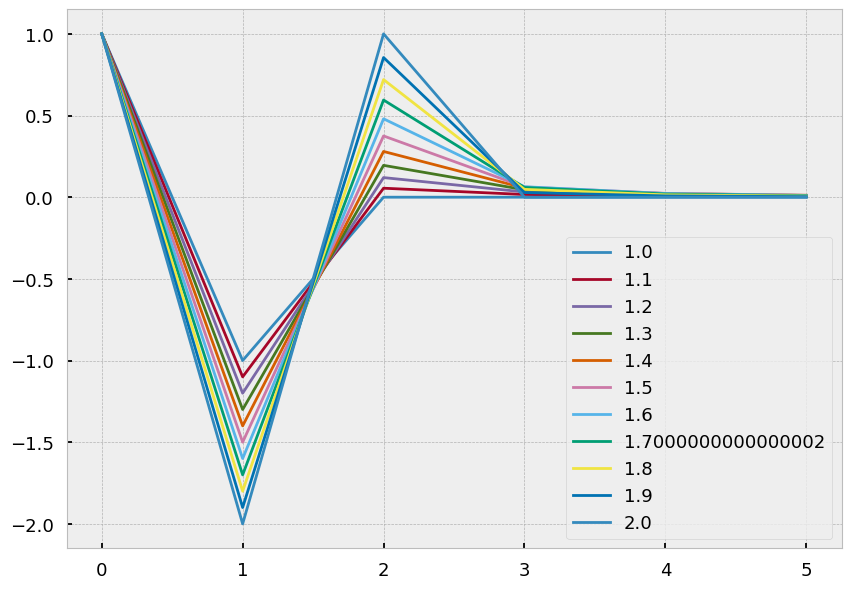

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# SNIPPET 5.1 WEIGHTING FUNCTION
def getWeights(d, size):
    # thres > 0 drops insignificant weights
    w = [1.]
    for k in range(1, size):
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

# Function to plot weights
def plotWeights(dRange, nPlots, size):
    w = pd.DataFrame()
    for d in np.linspace(dRange[0], dRange[1], nPlots):
        w_ = getWeights(d, size=size)
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w = w.join(w_, how='outer')
    ax = w.plot()
    ax.legend(loc='lower right')  # Use 'lower right' to place the legend in the right bottom corner
    plt.show()
    return

# Running the function
if __name__ == '__main__':
    plotWeights(dRange=[0, 1], nPlots=11, size=6)
    plotWeights(dRange=[1, 2], nPlots=11, size=6)


In [54]:
# SNIPPET 5.2 STANDARD FRACDIFF (EXPANDING WINDOW)
def fracDiff(series, d, thres=.01):
    '''
    Increasing width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped.
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    '''
    #1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_ > thres].shape[0]
    
    #3) Apply weights to values
    df = {}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        seriesF = pd.to_numeric(seriesF[name], errors='coerce')  # Convert to numeric, coercing errors to NaN
        df_ = pd.Series(dtype='float64')
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            if not np.isfinite(seriesF.loc[loc]):  # Check if the value is finite
                continue  # exclude NAs
            
            # Adjust the np.dot function to handle 1D array
            weight_subset = w[-(iloc + 1):].reshape(-1)  # Reshape to 1D array
            value_subset = seriesF.loc[:loc].values  # Get the values to match the weights
            
            df_[loc] = np.dot(weight_subset, value_subset)
            
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [55]:
close

,close
time_close,
2009-09-29 13:23:42,51.730
2009-10-01 13:44:06,50.270
2009-10-02 14:37:25,49.761
2009-10-07 11:39:00,51.090
2009-10-12 14:24:38,51.990
...,...
2024-07-25 11:50:36,188.400
2024-07-25 14:46:14,187.685
2024-07-26 10:11:15,189.020


In [72]:
D = 0.4
THRESH = 1.0
SERIES = close

diff_close = fracDiff(SERIES,D,THRESH)

In [73]:
diff_close

,close
2009-09-29 13:23:42,51.730000
2009-10-01 13:44:06,29.578000
2009-10-02 14:37:25,23.445400
2009-10-07 11:39:00,21.842480
2009-10-12 14:24:38,20.213432
...,...
2024-07-25 11:50:36,8.739188
2024-07-25 14:46:14,7.399620
2024-07-26 10:11:15,8.840881
2024-07-26 15:59:52,8.734908


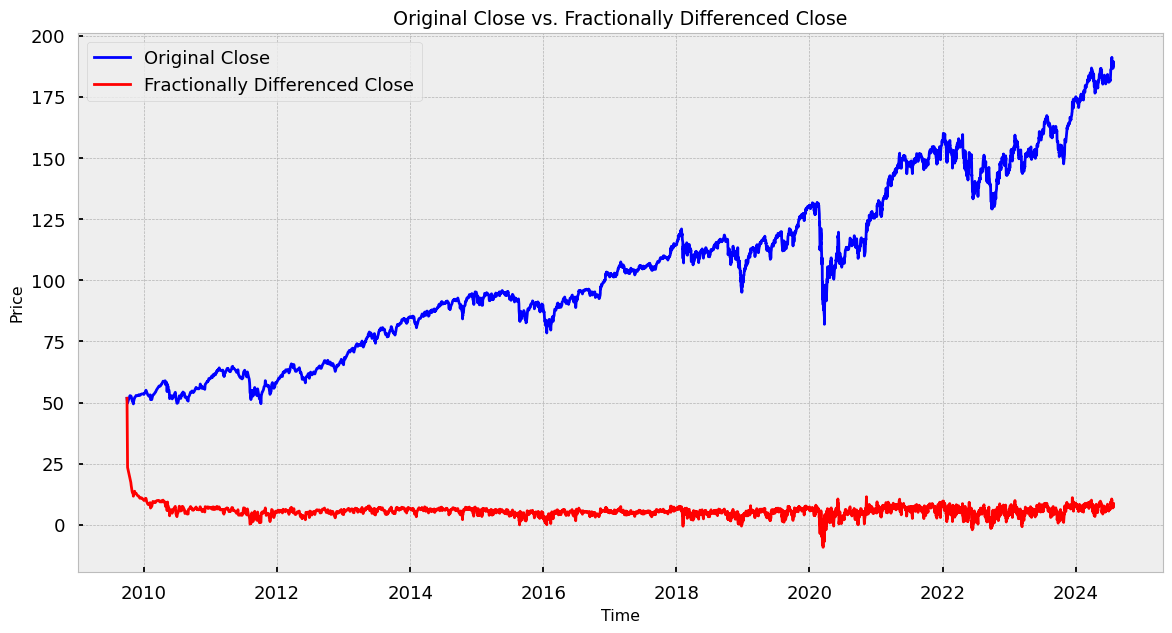

In [74]:
# Plot the original close series
plt.figure(figsize=(14, 7))
plt.plot(close.index, close['close'], label='Original Close', color='blue')

# Plot the fractionally differenced close series
plt.plot(diff_close.index, diff_close['close'], label='Fractionally Differenced Close', color='red')

# Add titles and labels
plt.title('Original Close vs. Fractionally Differenced Close')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='best')

# Show the plot
plt.show()

In [83]:
D = 0.4
THRESH = 0.01
SERIES = close

diff_close = fracDiff(SERIES,D,THRESH)

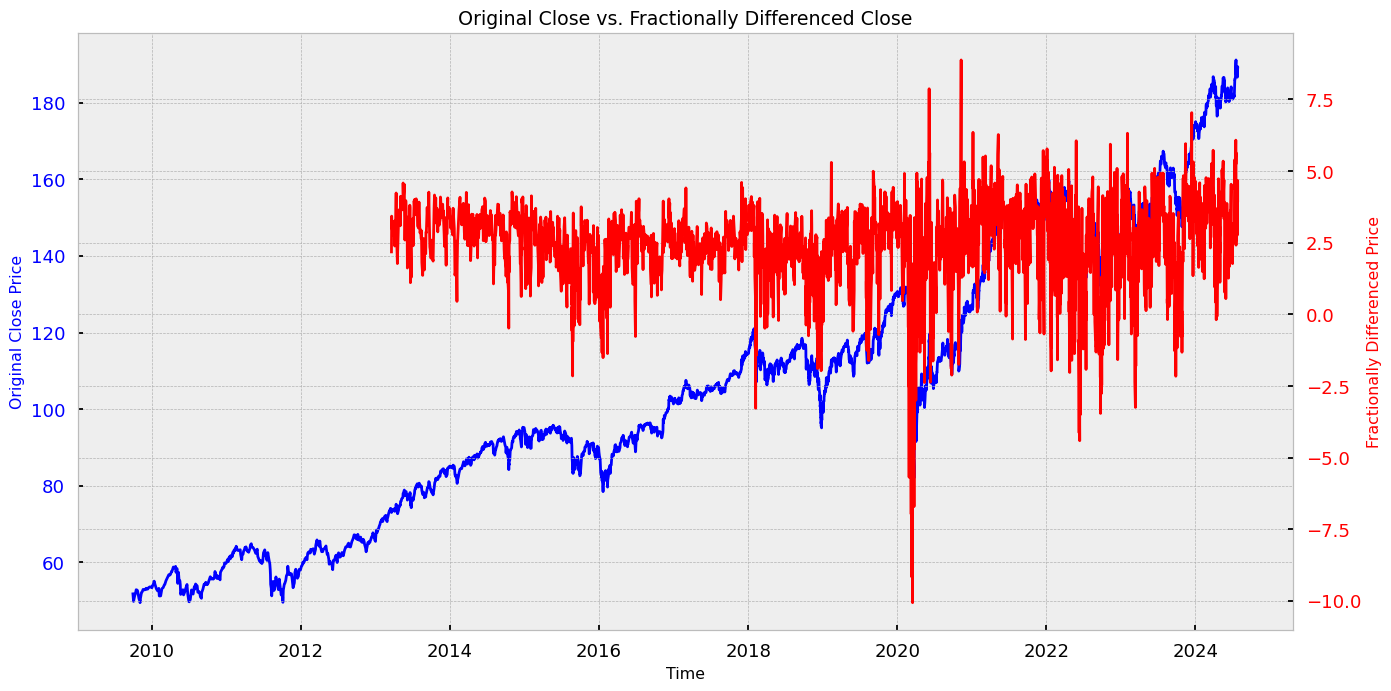

In [84]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the original close series on the primary y-axis
ax1.plot(close.index, close['close'], label='Original Close', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Original Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the fractionally differenced close series on the secondary y-axis
ax2.plot(diff_close.index, diff_close['close'], label='Fractionally Differenced Close', color='red')
ax2.set_ylabel('Fractionally Differenced Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add titles and labels
plt.title('Original Close vs. Fractionally Differenced Close')
fig.tight_layout()  # Adjust the layout

# Show the plot
plt.show()

In [105]:
# SNIPPET 5.3 THE NEW FIXED-WIDTH WINDOW FRACDIFF METHOD
def fracDiff_FFD(series, d, thres=1e-5):
    '''
    Constant width window (new solution)
    Note 1: thres determines the cut-off weight for the window
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    '''
    #1) Compute weights for the longest series
    w = getWeights_FFD(d, thres)
    width = len(w) - 1
    #2) Apply weights to values
    df = {}
    for name in series.columns:
        # Corrected the fill method to 'ffill'
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc1-width], seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue  # exclude NAs
            df_[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0, 0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df


def getWeights_FFD(d, thres):
    # Appends while the last weight is above the threshold
    w = [1.]
    while abs(w[-1]) > thres:
        w_ = -w[-1] / len(w) * (d - len(w) + 1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w


In [111]:
D = 0.4
THRESH = 1e-5
SERIES = close

diff_close = fracDiff_FFD(SERIES,D,THRESH)
diff_close

,close
2017-12-28 18:30:00,6.316385
2018-01-02 09:39:15,6.119453
2018-01-02 14:31:10,6.150162
2018-01-03 13:26:54,6.732035
2018-01-04 10:50:56,7.080594
...,...
2024-07-25 11:50:36,10.083817
2024-07-25 14:46:14,8.744873
2024-07-26 10:11:15,10.186755
2024-07-26 15:59:52,10.081401


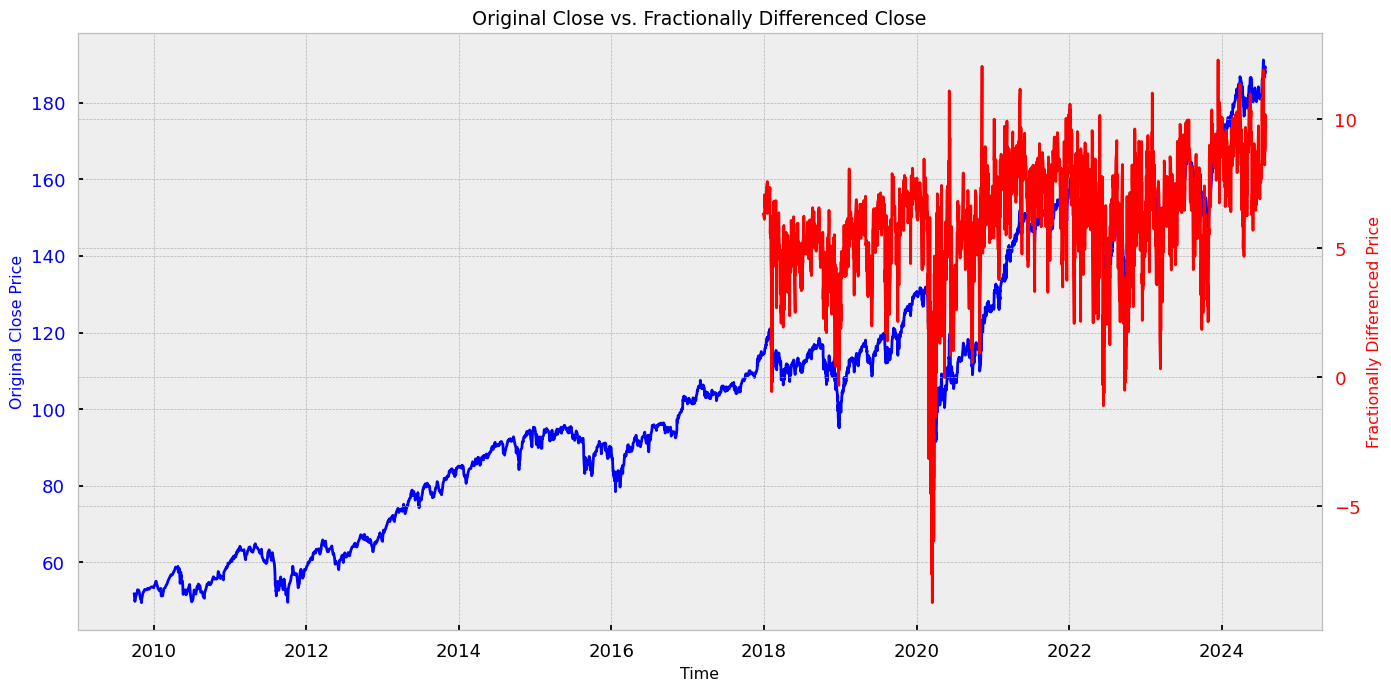

In [112]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the original close series on the primary y-axis
ax1.plot(close.index, close['close'], label='Original Close', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Original Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the fractionally differenced close series on the secondary y-axis
ax2.plot(diff_close.index, diff_close['close'], label='Fractionally Differenced Close', color='red')
ax2.set_ylabel('Fractionally Differenced Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add titles and labels
plt.title('Original Close vs. Fractionally Differenced Close')
fig.tight_layout()  # Adjust the layout

# Show the plot
plt.show()

In [113]:
# SNIPPET 5.4 FINDING THE MINIMUM D VALUE THAT PASSES THE ADF TEST

def plotMinFFD():
    from statsmodels.tsa.stattools import adfuller
    path,instName='./','ES1_Index_Method12'
    out=pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr'])
    df0=pd.read_csv(path+instName+'.csv',index_col=0,parse_dates=True)
    for d in np.linspace(0,1,11):
        df1=np.log(df0[['Close']]).resample('1D').last() # downcast to daily obs
        df2=fracDiff_FFD(df1,d,thres=.01)
        corr=np.corrcoef(df1.loc[df2.index,'Close'],df2['Close'])[0,1]
        df2=adfuller(df2['Close'],maxlag=1,regression='c',autolag=None)
        out.loc[d]=list(df2[:4])+[df2[4]['5%']]+[corr] # with critical value
    out.to_csv(path+instName+'_testMinFFD.csv')
    out[['adfStat','corr']].plot(secondary_y='adfStat')
    mpl.axhline(out['95% conf'].mean(),linewidth=1,color='r',linestyle='dotted')
    mpl.saveﬁg(path+instName+'_testMinFFD.png')
    return

Fractional differentiation order: 0.0, ADF Statistic: -1.6433588404918646, Correlation: 0.9999999999999998
Fractional differentiation order: 0.05, ADF Statistic: -1.5061324504554783, Correlation: 0.999986839813799
Fractional differentiation order: 0.1, ADF Statistic: -1.5668250810994948, Correlation: 0.9999015883027453
Fractional differentiation order: 0.15000000000000002, ADF Statistic: -1.633615206409744, Correlation: 0.9996742045026781
Fractional differentiation order: 0.2, ADF Statistic: -1.7960516677732166, Correlation: 0.9992393449521045
Fractional differentiation order: 0.25, ADF Statistic: -2.0359134203498446, Correlation: 0.9984243972687956
Fractional differentiation order: 0.30000000000000004, ADF Statistic: -2.334065219554646, Correlation: 0.997206970750426
Fractional differentiation order: 0.35000000000000003, ADF Statistic: -2.729202383855239, Correlation: 0.9952490042863723
Fractional differentiation order: 0.4, ADF Statistic: -3.151688608245603, Correlation: 0.9928540167

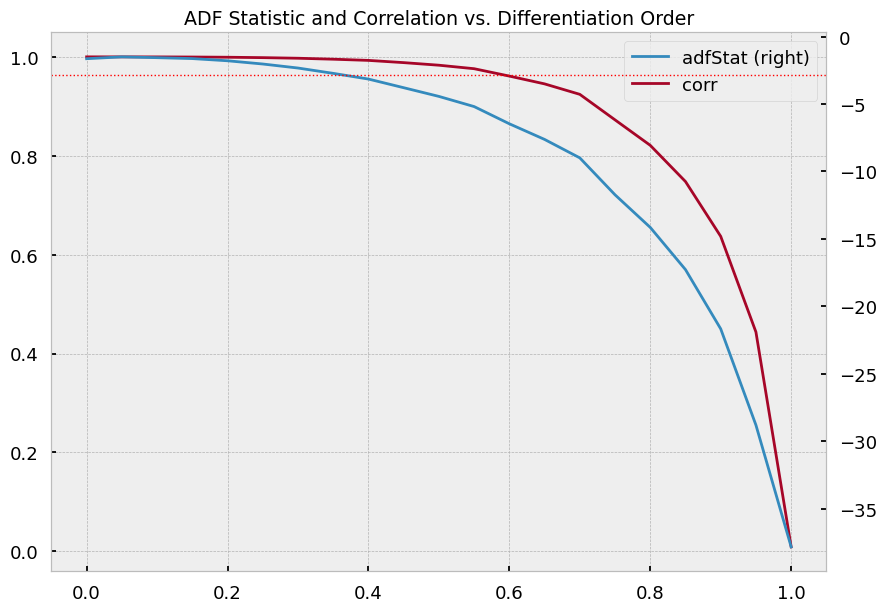

In [157]:
def plotMinFFD(df):
    from statsmodels.tsa.stattools import adfuller
    import matplotlib.pyplot as plt
    d_found = False
    
    out = pd.DataFrame(columns=['adfStat', 'pVal', 'lags', 'nObs', '95% conf', 'corr'])
    
    # Assuming 'Close' is the column name in df
    for d in np.linspace(0, 1, 21):
        df1 = np.log(df[['close']]).resample('1D').last()  # Downcast to daily observations
        df2 = fracDiff_FFD(df1, d, thres=.01)
        corr = np.corrcoef(df1.loc[df2.index, 'close'], df2['close'])[0, 1]
        adf_result = adfuller(df2['close'], maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(adf_result[:4]) + [adf_result[4]['5%']] + [corr]  # With critical value
        print(f'Fractional differentiation order: {d}, ADF Statistic: {adf_result[0]}, Correlation: {corr}')
        if not d_found and adf_result[1] < 0.05:
            d_found = True
            d_req = d
            print(f'Fractional differentiation order found: {d_req}')

    # Plotting the results
    out[['adfStat', 'corr']].plot(secondary_y='adfStat')
    plt.axhline(out['95% conf'].mean(), linewidth=1, color='r', linestyle='dotted')
    plt.title('ADF Statistic and Correlation vs. Differentiation Order')
    plt.show()
    
    return out, d_req

# Assuming 'df' is the DataFrame in the local environment
result, d = plotMinFFD(close)


In [158]:
d

0.4

To summarize, most econometric analyses follow one of two paradigms:

1. **Box-Jenkins**: Returns are stationary, however memory-less.
2. **Engle-Granger**: Log-prices have memory, however they are non-stationary.\
Cointegration is the trick that makes regression work on non-stationary\
series, so that memory is preserved. However the number of cointegrated\
variables is limited, and the cointegrating vectors are notoriously unstable.

In contrast, the FFD approach introduced in this chapter shows that there is\
no need to give up all of the memory in order to gain stationarity. And there\
is no need for the cointegration trick as it relates to ML forecasting. Once\
you become familiar with FFD, it will allow you to achieve stationarity without\
renouncing to memory (or predictive power).

In practice, I suggest you experiment with the following transformation of your\
features: First, compute a cumulative sum of the time series. This guarantees\
that some order of differentiation is needed. Second, compute the FFD(d) series\
for various d ∈ [0, 1]. Third, determine the minimum d such that the p-value of\
the ADF statistic on FFD(d) falls below 5%. Fourth, use the FFD(d) series as\
your predictive feature.


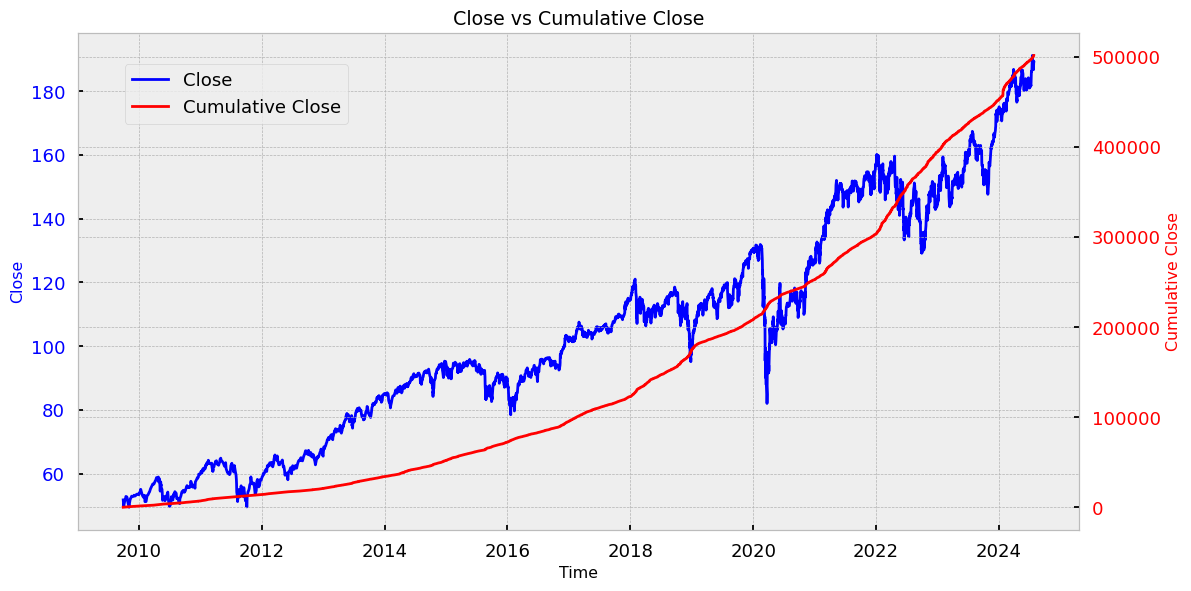

In [159]:
# First, compute a cumulative sum of the time series. This guarantees that some
def plot_yAndCumulativeY(df):
    # order of differentiation is needed.
    cumulative_close = df['close'].cumsum()

    # Plotting the close and cumulative close with different y-axis scales
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot the Close on the primary y-axis
    ax1.plot(df.index, df['close'], color='blue', label='Close')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Close', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis for the Cumulative Close
    ax2 = ax1.twinx()
    ax2.plot(df.index, cumulative_close, color='red', label='Cumulative Close')
    ax2.set_ylabel('Cumulative Close', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Add a title
    plt.title('Close vs Cumulative Close')

    # Add legends
    fig.tight_layout()
    fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

    # Show the plot
    plt.show()
    return pd.DataFrame(cumulative_close)

cumulative_close = plot_yAndCumulativeY(close)


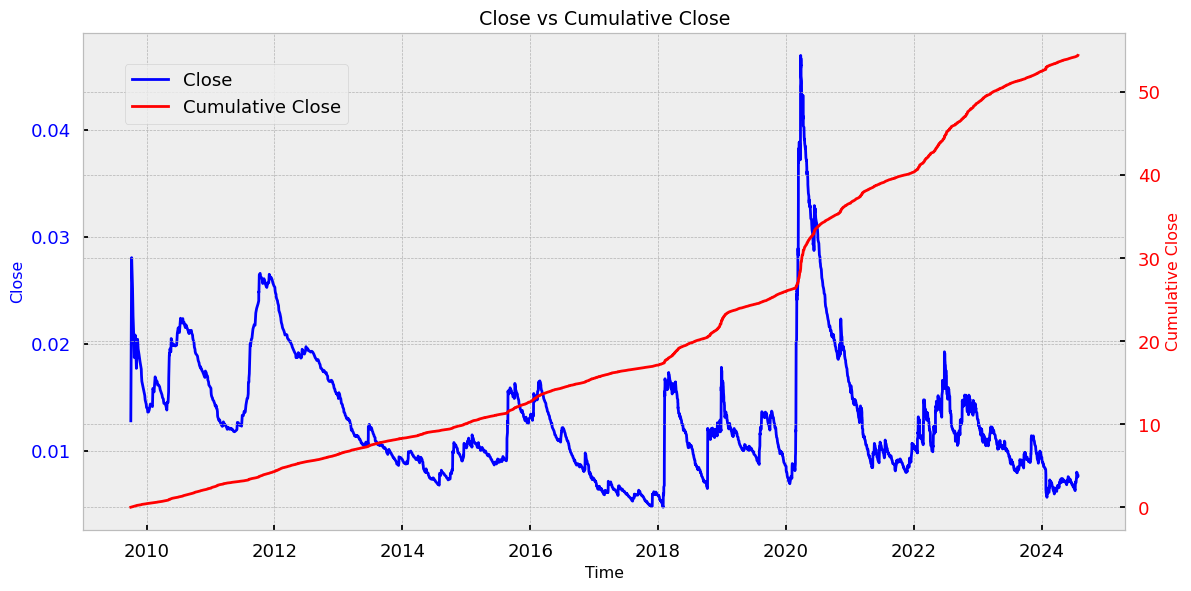

,close
time_close,
2009-10-02 14:37:25,0.012797
2009-10-07 11:39:00,0.040851
2009-10-12 14:24:38,0.066015
2009-10-15 12:03:22,0.088588
2009-10-20 11:12:37,0.108867
...,...
2024-07-25 11:50:36,54.354137
2024-07-25 14:46:14,54.361685
2024-07-26 10:11:15,54.369329


In [160]:
cumulative_vol = plot_yAndCumulativeY(dailyVol)
cumulative_vol

Fractional differentiation order: 0.0, ADF Statistic: -28.1171081983107, Correlation: 1.0
Fractional differentiation order found: 0.0
Fractional differentiation order: 0.05, ADF Statistic: -23.244989331602266, Correlation: 0.9999952978785809
Fractional differentiation order: 0.1, ADF Statistic: -12.879563117019337, Correlation: 0.99998530112393
Fractional differentiation order: 0.15000000000000002, ADF Statistic: -13.943480277433018, Correlation: 0.9999420683071392
Fractional differentiation order: 0.2, ADF Statistic: -16.891877453310883, Correlation: 0.9999163793449485
Fractional differentiation order: 0.25, ADF Statistic: -25.557470747487177, Correlation: 0.9998195154860093
Fractional differentiation order: 0.30000000000000004, ADF Statistic: -29.686690764653857, Correlation: 0.9996895002238765
Fractional differentiation order: 0.35000000000000003, ADF Statistic: -29.584327160338113, Correlation: 0.9994871488194144
Fractional differentiation order: 0.4, ADF Statistic: -26.66812336776

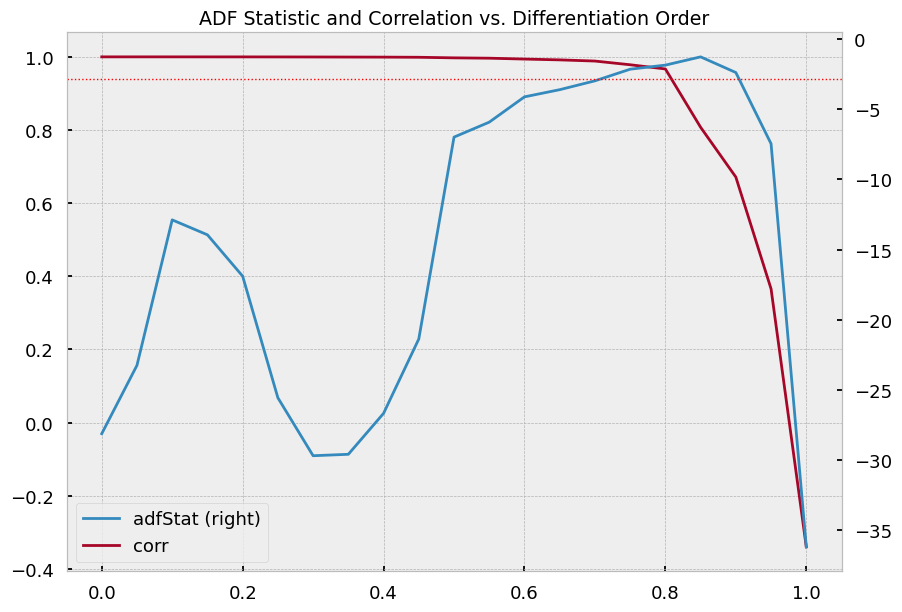

In [161]:
# Second, compute the FFD(d) series for various d ∈ [0, 1]
result, d = plotMinFFD(cumulative_vol)

In [162]:
result

,adfStat,pVal,lags,nObs,95% conf,corr
0.00,-28.117108,0.000000e+00,1.0,2764.0,-2.862586,1.000000
0.05,-23.244989,0.000000e+00,1.0,2764.0,-2.862586,0.999995
0.10,-12.879563,4.690190e-24,1.0,2763.0,-2.862587,0.999985
0.15,-13.943480,4.844283e-26,1.0,2763.0,-2.862587,0.999942
0.20,-16.891877,1.043592e-29,1.0,2762.0,-2.862587,0.999916
...,...,...,...,...,...,...
0.80,-1.851025,3.554393e-01,1.0,2763.0,-2.862587,0.966936
0.85,-1.262178,6.462934e-01,1.0,2764.0,-2.862586,0.807483
0.90,-2.378187,1.479879e-01,1.0,2764.0,-2.862586,0.671334
0.95,-7.453756,5.581977e-11,1.0,2764.0,-2.862586,0.365689


In [147]:
d

0.4